In [1]:
import numpy as np
import matplotlib.pyplot as plt

# !pip install networkx==2.6.3
import networkx as nx 
import scipy

%matplotlib inline

## Watts-Strogatz model

The model is built from a regular graph $G(N,d)$, each edge $(i,j)$ is swapped into $(i,l)$ with probability $\beta$, $l$ - is a randomly selected node ($l\ne i,l \ne j$).


In [2]:
ws1=nx.watts_strogatz_graph(40,4,0.0)

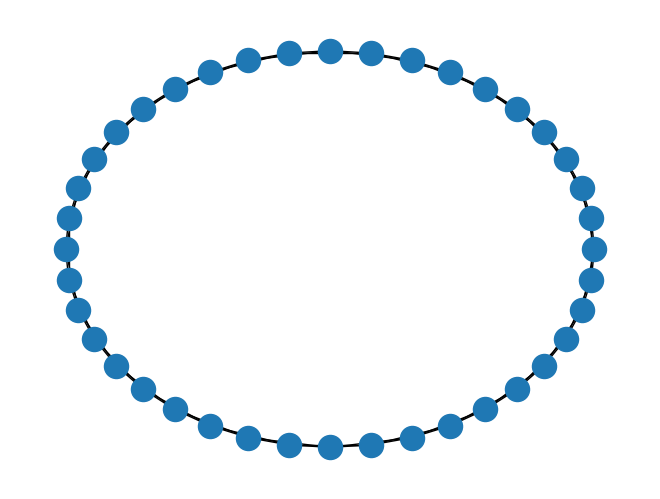

In [3]:
pos = nx.circular_layout(ws1)
nx.draw(ws1, pos = pos)

C:\Users\kuzne\AppData\Local\Temp\ipykernel_31176\4040744292.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A=nx.adjacency_matrix(ws1).A
C:\Users\kuzne\AppData\Local\Temp\ipykernel_31176\4040744292.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A=nx.adjacency_matrix(ws2).A
C:\Users\kuzne\AppData\Local\Temp\ipykernel_31176\4040744292.py:18: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A=nx.adjacency_matrix(ws3).A


Text(0.5, 1.0, '$\\beta=1.0$')

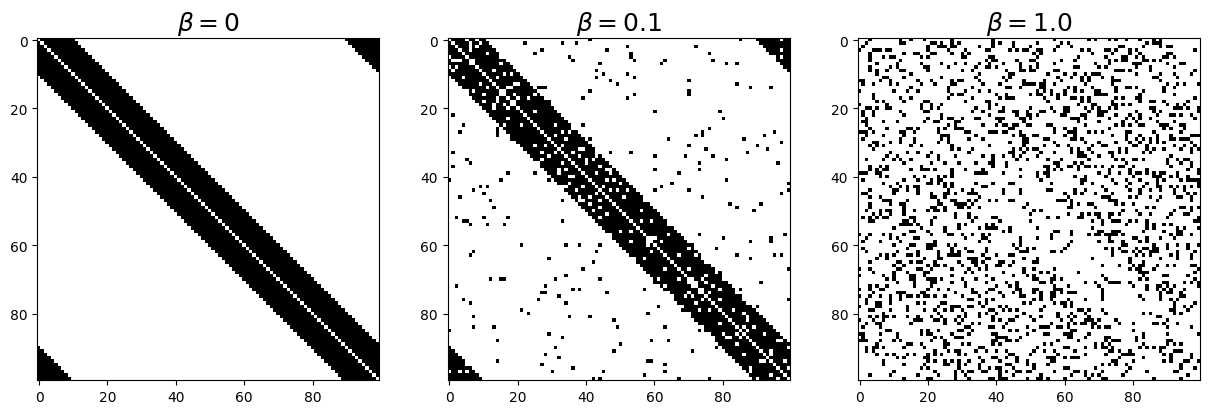

In [4]:
plt.figure(figsize=(15, 5))
ax1=plt.subplot(131)
ws1=nx.watts_strogatz_graph(100,20,0.0) # regular
A=nx.adjacency_matrix(ws1).A
plt.imshow(A,cmap='binary')
ax1.set_title(r'$\beta=0$',fontsize=18)


ax1=plt.subplot(132)
ws2=nx.watts_strogatz_graph(100,20,0.1) # less regular
A=nx.adjacency_matrix(ws2).A
plt.imshow(A,cmap='binary')
ax1.set_title(r'$\beta=0.1$',fontsize=18)


ax1=plt.subplot(133)
ws3=nx.watts_strogatz_graph(100,20,1.0) # not regular at all
A=nx.adjacency_matrix(ws3).A
plt.imshow(A,cmap='binary')
ax1.set_title(r'$\beta=1.0$',fontsize=18)

In [5]:
for beta in [0.0,0.2,1.0]:
    ws=nx.watts_strogatz_graph(1000,10,beta)
    print(nx.diameter(ws))
    print(nx.average_clustering(ws))
    print('----------------')

100
0.6666666666666636
----------------
6
0.34898432123432166
----------------
5
0.007573952191599245
----------------


# Community detection

In [6]:
import pandas as pd
import random
import itertools

In [7]:
KC = nx.karate_club_graph()
groups = set(nx.get_node_attributes(KC,'club').values())
print(groups)

{'Mr. Hi', 'Officer'}


In [8]:
dict(zip(sorted(groups), itertools.count()))

{'Mr. Hi': 0, 'Officer': 1}

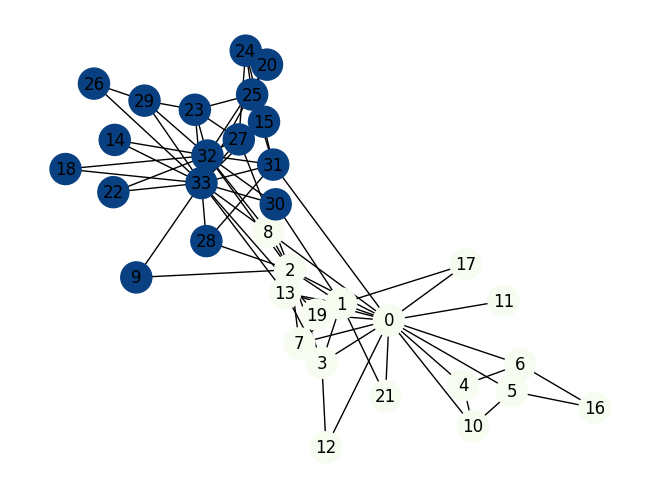

In [9]:
mapping = dict(zip(sorted(groups), itertools.count()))
nodes = KC.nodes()
colors = [mapping[KC.nodes[n]['club']] for n in nodes]
nx.draw(KC, node_size=500, with_labels=True, node_color=colors, cmap='GnBu')

## Hierarchical clustering
Methods aiming to create a hierarchy of partitions into clusters



### Agglomerative methods (The Ravasz Algorithm)
Let $X$ be the similarity matrix with elements:
$$
x_{ij}=\frac{J(i,j)+A_{ij}}{min(k_i,k_j)+1-A_{ij}},
$$
$J(i,j)$-number of common neighbors of $i$ и $j$, A - adjacency matrix:

More theory: https://barabasi.com/f/618.pdf

In [10]:
def similarity_matrix(G, nodelist=None): # nodelist gives the ordering of nodes in a matrix
    if (nodelist is None):
        nodelist=list(G.nodes)

    Smatrix=np.zeros((len(nodelist), len(nodelist)))

    for i, node1 in enumerate(nodelist):
        for j, node2 in enumerate(nodelist[i+1:], start = i+1):
            Smatrix[i,j]=(len(set(G[node1]) & set(G[node2])) + int(G.has_edge(node1,node2)))/(np.min([len(G[node1]),len(G[node2])])
                                                                                          +1-int(G.has_edge(node1,node2)))
            Smatrix[j,i]=Smatrix[i,j]

    return Smatrix

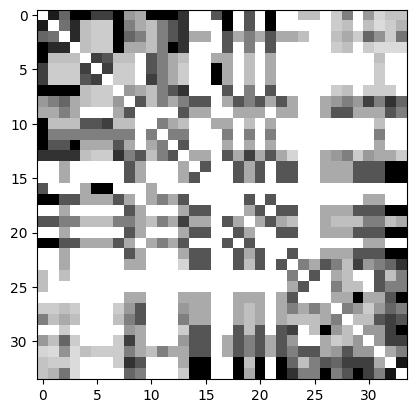

In [11]:
plt.imshow(similarity_matrix(KC,nodelist=None), cmap='binary') # порядок вершин произвольный

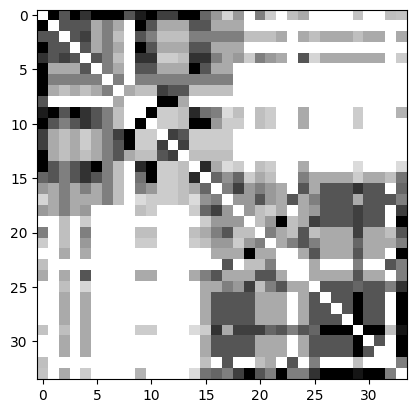

In [12]:
plt.imshow(similarity_matrix(KC,nodelist=list(np.argsort(colors))), cmap='binary') # nodes are sorted using community labels

New clusters are created by merging smaller ones. Thus the dendrogram is created from leaves to the trunc.
We use sklearn.cluster, more [here](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)

In [13]:
from sklearn.cluster import AgglomerativeClustering

communities = AgglomerativeClustering(linkage='average', n_clusters = 2)

In [14]:
X=similarity_matrix(KC,nodelist=None)
communities.fit(X)

c:\Users\kuzne\anaconda3\envs\network_science\lib\site-packages\sklearn\cluster\_agglomerative.py:544: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


AgglomerativeClustering(linkage='average')

In [15]:
y_pred=communities.labels_
y_true=np.array(colors)
print(y_pred)
print(y_true)

[0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


Characterizing accuracy:

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_true, y_pred))
print(accuracy_score(y_true, y_pred))

[[16  1]
 [ 0 17]]
0.9705882352941176


Dendrogram visualization:

In [17]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

c:\Users\kuzne\anaconda3\envs\network_science\lib\site-packages\sklearn\cluster\_agglomerative.py:544: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


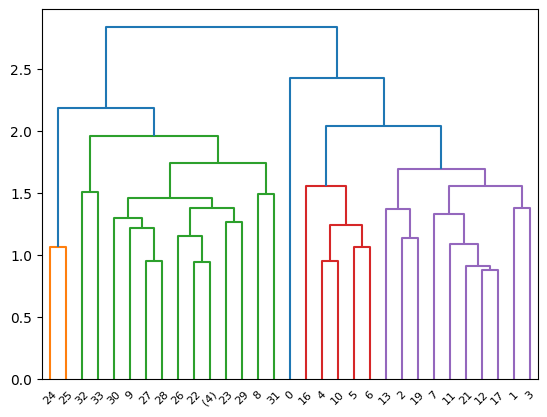

In [18]:
communities2=AgglomerativeClustering(linkage='average',distance_threshold=0, n_clusters=None)
communities2.fit(X)
plot_dendrogram(communities2, truncate_mode='level', p=7)

### Divisive methods
New clusters are created by dividing larger clusters into smaller ones and thus a tree is created from trunk to leaves.
The division into communities is done by removing edges from the original network. The connected components of the remaining network are communities. An edge to be removed is chosen by the highest value of centrality (influentiality) of the edge, which can be introduced by extending the definition of centrality for vertices. In particular, the betweenness centrality used in [the Girvan-Newman algorithm](https://www.pnas.org/content/99/12/7821) is introduced as the number of shortest paths between pairs of nodes that pass through that edge. 


In [19]:
from networkx.algorithms import community as com

In [20]:
comps = com.girvan_newman(KC)

In [21]:
comps

<generator object girvan_newman at 0x0000014D43D3A030>

In [22]:
for communities in itertools.islice(comps, 1):
    l=list(sorted(c) for c in communities)
    print(l)

[[0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]


Расставим метки принадлежности к сообществу и выведем метрики качества, заметим, если большинство меток "не совпадают" с истинными, нужно изменить нумерацию сообществ.

In [23]:
y_pred2=[]
for node in nodes:
    if node in l[0]:
        y_pred2.append(0)
    else:
        y_pred2.append(1)

In [24]:
print(confusion_matrix(y_true, y_pred2))
print(accuracy_score(y_true, y_pred2))

[[15  2]
 [ 0 17]]
0.9411764705882353


## Quality metrics

### Pairwise confusion matrix:
$$
A=\begin{pmatrix}
 a_{00} &  a_{01}\\
a_{10}& a_{11}
\end{pmatrix}	
$$

Consider all possible pairs of vertices:
* $a_{00}$ - the number of pairs belonging to the same community in the first and second partitions;
* $a_{01}$ - the number of pairs belonging to the same community in the first partition and to different ones in the second partition;
* $a_{10}$ - the number of pairs belonging to the same community in the second partition and to different ones in the first partition;
* $a_{11}$ - the number of pairs belonging to different communities in both the first and second partitioning;

Metrics based on matrix A:

1) [Rand indes](https://en.wikipedia.org/wiki/Rand_index)
$$
R=\frac{a_{00}+a_{11}}{a_{00}+a_{01}+a_{10}+a_{11}}
$$
2) Jaccard index
$$
J=\frac{a_{00}}{a_{00}+a_{01}+a_{10}}
$$

### [Mutual information](https://en.wikipedia.org/wiki/Mutual_information) 
$$
MI=H(U) + H(V) - H(UV),
$$
$H(UV)$-joint entropy, $H(U)$,$H(V)$ - entropies;
$$
NMI=\frac{MI}{mean(H(U),H(V))}
$$

In [25]:
from sklearn.metrics import mutual_info_score
from sklearn.metrics.cluster import normalized_mutual_info_score

In [26]:
mutual_info_score([1,1,1,1,0,0,0,0],[1,1,1,1,1,1,1,0])

0.09560258894703255

Modularity is a functional that determines the optimality of network partitioning into communities:
$$
M=\frac{1}{2L}\sum_{i,j}^N\left(A_{ij}-\frac{k_ik_j}{2L}\right)\delta_{C_i,C_j},
$$

$L$ is the number of edges in the network, $A$ is the adjacency matrix, $k_i$ is the degree of vertex $i$, $C_i$ is the label of vertex $i$ that determines community membership, i.e. 
$\delta_{C_i,C_j} = 1$ if $i$ and $j$ belong to the same community, otherwise $\delta_{C_i,C_j} = 0$.

In [27]:
coms=[set(n for n in nodes if (mapping[KC.nodes[n]['club']]==0)), set(n for n in nodes if (mapping[KC.nodes[n]['club']]==1))] 

print(com.modularity(KC,coms))

0.39143756676224206


## Modularity optimization

In [28]:
m=com.greedy_modularity_communities(KC, n_communities=2)
print(com.modularity(KC,m))

0.41096493693896297


## The Leuven Algorithm 

An iterative algorithm for finding a community partitioning with the maximum modularity value:
$$
M=\frac{1}{2L}\sum_{i,j}^N\left(W_{ij}-\frac{k_ik_j}{2L}\right)\delta_{C_i,C_j}.
$$

The algorithm consists of the following steps:
First, we assign each node of the weighted network its own community (node index). 
* Step I. For each node $i$, compute the modularity change $\delta M$ when that node moves into the communities of its nearest neighbor $j$.
$$
\delta M=\left[ \frac{\sum_{in}+2k_{i,in}}{2W} -\left(\frac{ \sum_{tot}+k_i}{2W}\right)^2\right] - \left[ \frac{\sum_{in}}{2W} - \left(\frac{\sum_{tot}}{2W} \right)^2- \left(\frac{k_i}{2W} \right)^2 \right],
$$
where $\sum_{in}$ is the sum of weights within community $C$, $\sum_{tot}$ is the sum of weighted degrees of all community vertices, $k_i$ is the weighted degree of vertex $i$, $k_{i,in}$ is the sum of weights of edges connecting vertices $i$ and community vertices $C$, $W$ is the sum of weights of all network vertices.
 Assign to vertex $i$ the community that gives the largest $\delta M$. Repeat for all vertices $i$. 
* Step II. Construct a new network whose vertices are the communities identified in step I. The weight of the connection between two vertices is the sum of the weight of connections between vertices in the corresponding communities. Connections between vertices of the same community lead to weighted loops.

* Repeat Step I-II. 

In [38]:
from networkx.algorithms.community import louvain_communities as community_louvain
lv = community_louvain.best_partition(KC)

AttributeError: 'function' object has no attribute 'best_partition'

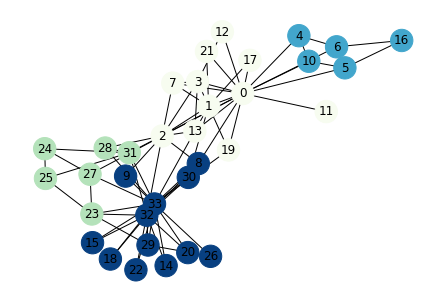

In [ ]:
nx.draw(KC, node_size=500, with_labels=True, node_color=list(lv.values()), cmap='GnBu')

In [ ]:
coms=[]
for i in range(max(lv.values())+1):
    coms.append(set(n for n in KC.nodes() if (lv[n]==i)))

print(com.modularity(KC,coms))

0.41978961209730437


## A model for testing community detection methods

One benchmark for testing community detection methods is a block-stochastic network. The network in the model is defined by cluster sizes and link probabilities within each cluster and in pairs between clusters:

In [ ]:
sizes = [50, 50, 100]
probs = [[0.2, 0.01, 0.01], 
         [0.01, 0.3, 0.03], 
         [0.01, 0.03, 0.40]]


bg = nx.stochastic_block_model(sizes, probs, seed=0)

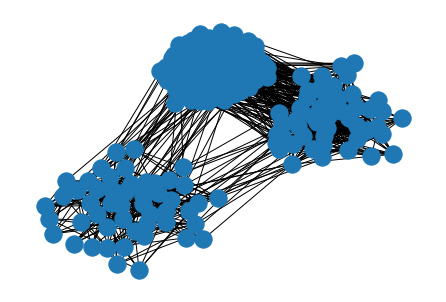

In [ ]:
nx.draw(bg)

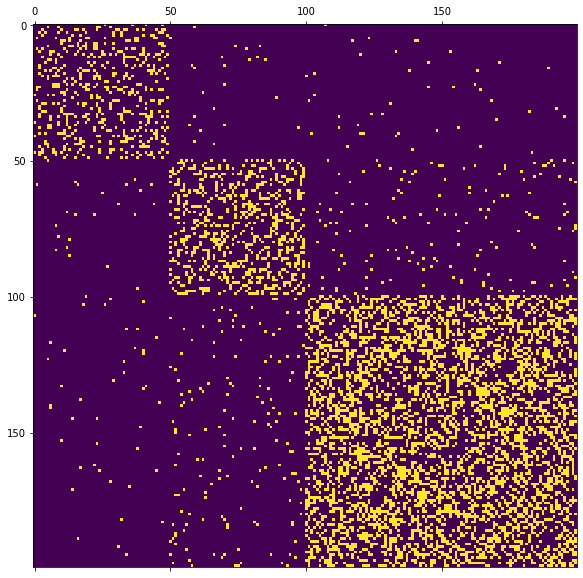

In [ ]:
A = nx.adjacency_matrix(bg).A

fig, ax = plt.subplots(figsize = (10,10))
ax.matshow(A)